<a href="https://colab.research.google.com/github/md2383/SeminarInAI/blob/main/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project - Interactive xG Modeling and Analysis with Language Model Integration

**Description:**  
This project explores the development of a simple expected goals (xG) prediction system using open-source shot data from the 2018 FIFA World Cup (statsbomb). A linear regression model was trained to estimate xG values based on features such as shot distance, angle, body part, and technique. The system is enhanced with a suite of custom data-querying functions that enable a language model (LLM) to interpret and respond to natural language questions. These include per-shot, player, and team-level analyses. The LLM is also used to generate user-friendly explanations and summaries of the results. This multimodal integration highlights the potential of combining interpretable sports analytics models with natural language interfaces.

### Step 1 - Data Collection and Exploration

In [ ]:
#!pip install statsbombpy
from statsbombpy import sb

In [ ]:
# Available competitions
comps = sb.competitions()
sb.competitions()

,competition_id,season_id,country_name,competition_name,competition_gender,competition_youth,competition_international,season_name,match_updated,match_updated_360,match_available_360,match_available
0,9,281,Germany,1. Bundesliga,male,False,False,2023/2024,2024-07-15T14:15:54.671676,2024-07-15T14:17:00.877356,2024-07-15T14:17:00.877356,2024-07-15T14:15:54.671676
1,9,27,Germany,1. Bundesliga,male,False,False,2015/2016,2024-05-19T11:11:14.192381,None,None,2024-05-19T11:11:14.192381
2,1267,107,Africa,African Cup of Nations,male,False,True,2023,2024-06-13T07:51:02.452825,None,None,2024-06-13T07:51:02.452825
3,16,4,Europe,Champions League,male,False,False,2018/2019,2024-06-12T07:44:38.559714,2021-06-13T16:17:31.694,None,2024-06-12T07:44:38.559714
4,16,1,Europe,Champions League,male,False,False,2017/2018,2024-02-13T02:35:28.134882,2021-06-13T16:17:31.694,None,2024-02-13T02:35:28.134882
...,...,...,...,...,...,...,...,...,...,...,...,...
69,55,43,Europe,UEFA Euro,male,False,True,2020,2024-04-16T12:44:40.558402,2024-04-16T12:47:18.505110,2024-04-16T12:47:18.505110,2024-04-16T12:44:40.558402
70,35,75,Europe,UEFA Europa League,male,False,False,1988/1989,2024-02-12T14:45:05.702250,2021-06-13T16:17:31.694,None,2024-02-12T14:45:05.702250
71,53,106,Europe,UEFA Women's Euro,female,False,True,2022,2024-02-13T13:27:17.178263,2024-02-13T13:30:52.820588,2024-02-13T13:30:52.820588,2024-02-13T13:27:17.178263
72,72,107,International,Women's World Cup,female,False,True,2023,2024-07-14T16:59:48.469596,2024-07-14T17:01:38.887279,2024-07-14T17:01:38.887279,2024-07-14T16:59:48.469596


We are using Data from the 2018 Fifa World Cup as this data is free

In [ ]:
# Find the World Cup 2018 details (competition_id, season_id, season_name, competition_name)
wc2018 = comps[
    (comps['season_name'] == '2018') &
    (comps['competition_name'] == 'FIFA World Cup')
]
print(wc2018)

    competition_id  season_id   country_name competition_name  \
30              43          3  International   FIFA World Cup   

   competition_gender  competition_youth  competition_international  \
30               male              False                       True   

   season_name               match_updated        match_updated_360  \
30        2018  2024-06-12T07:38:19.345758  2021-06-13T16:17:31.694   

   match_available_360             match_available  
30                None  2024-06-12T07:38:19.345758  


In [ ]:
# For World Cup 2018
competition_id = wc2018.iloc[0]['competition_id'] # FIFA World Cup
season_id = wc2018.iloc[0]['season_id'] # 2018 season

#print(competition_id, season_id)

matches = sb.matches(competition_id=competition_id, season_id=season_id)
print(matches[['match_id', 'home_team', 'away_team', 'competition_stage']].head())

print("Total number of matches: ", len(matches))

   match_id home_team    away_team competition_stage
0      7585  Colombia      England       Round of 16
1      7570   England      Belgium       Group Stage
2      7586    Sweden  Switzerland       Round of 16
3      7557      Iran     Portugal       Group Stage
4      7542  Portugal      Morocco       Group Stage
Total number of matches:  64


Because of the limits of the open access data, we have only 5 games for our model, Lets look at game #5 Portugal vs Morocco to undertsand the data structure

In [ ]:
match5_id = 7542

events = sb.events(match_id=match5_id)
shots = events[events['type'] == 'Shot'].copy()
shots['player'] = shots['player'].fillna('Unknown')
shots['team'] = shots['team'].fillna('Unknown')
shots['is_goal'] = shots['shot_outcome'].apply(lambda x: isinstance(x, dict) and x.get('name') == 'Goal')

#print(shots.columns.tolist())
shot_lst = shots[['minute', 'player', 'team', 'location', 'shot_statsbomb_xg', 'shot_outcome', 'player', 'team', 'is_goal']].head()

### Setting up the Model

In [ ]:
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
import pandas as pd

In [ ]:
# Gets the distance of a shot from a location on the field
# location: [x, y] <-- X is the distance from goal line, Y is the distance from the touchline. This means (120, 40) is the center of the goal.
def get_distance(location):

    # Handling the case where location is missing or invalid
    if not isinstance(location, list) or len(location) != 2:
        return np.nan

    # Split the location into x and y coordinates
    x = location[0]
    y = location[1]

    # Calculate the distance from the center of the goal (120, 40)
    # Note here we are using euclidean distance to the center of the goal (120, 40)
    distance = np.sqrt((120 - x)** 2 + (40 - y)** 2)
    return distance

# Gets the angle of a shot from a location on the field
# location: [x, y] <-- Same as get_distance's location parameter
def get_angle(location):
    # Handling the case where location is missing or invalid
    if not isinstance(location, list) or len(location) != 2:
        return np.nan

    # Split the location into x and y coordinates
    x = location[0]
    y = location[1]

    # Goalposts are at (120, 36) and (120, 44) — 8 yards wide
    # Here we find the horizontal distance to the goal line (120) and the vertical distance to each post
    h_distance = 120 - x    # horizontal distance to goal line
    v_distance_bp = 36 - y  # bottom post
    v_distance_tp = 44 - y  # top post

    # Calculate the angles to each post using arctan
    shot_angle_bp = np.arctan2(v_distance_bp, h_distance)
    shot_angle_tp = np.arctan2(v_distance_tp, h_distance)

    # Calculate the angle between the two posts
    angle_between_posts = np.abs(shot_angle_tp - shot_angle_bp)

    # return the angle in radians
    return angle_between_posts

def get_angle_degrees(location):
    return (get_angle(location) * (180 / np.pi))  # Convert radians to degrees

In [ ]:
shots['player'] = shots['player'].fillna('Unknown')
shots['team'] = shots['team'].fillna('Unknown')
shots['is_goal'] = shots['shot_outcome'].apply(lambda x: isinstance(x, dict) and x.get('name') == 'Goal')

shots['distance'] = shots['location'].apply(get_distance) # Save the distance of the shot from the goal line
shots['angle'] = shots['location'].apply(get_angle) # Save the angle of the shot from the goal line
shots['angle_degrees'] = shots['location'].apply(get_angle_degrees) # this is added for convenience and debugging, easier to read than radians

In [ ]:
# We have some issues with missing values in the data, so lets find out why:
# shots['player'] = shots['player'].apply(lambda x: x['name'] if isinstance(x, dict) else 'Unknown')
# shots['team'] = shots['team'].apply(lambda x: x['name'] if isinstance(x, dict) else 'Unknown')

# unknowns = shots[(shots['player'] == 'Unknown') | (shots['team'] == 'Unknown')]
# print(unknowns[['minute', 'location', 'shot_technique', 'shot_outcome']].head(10))

# I was incorrectly formatting the player and team names, so simple fix:
shots['player'] = shots['player'].fillna('Unknown')
shots['team'] = shots['team'].fillna('Unknown')

In [ ]:
required = ['player', 'team', 'distance', 'angle', 'angle_degrees',
            'shot_statsbomb_xg', 'shot_body_part', 'shot_technique',
            'shot_type', 'shot_outcome']

model_data = shots[required].dropna().copy()
model_data['is_goal'] = shots['shot_outcome'].apply(lambda x: isinstance(x, dict) and x.get('name') == 'Goal')

In [ ]:
# Preprocess the categorical features using OneHotEncoder
categorical_features = ['shot_body_part', 'shot_technique', 'shot_type']
numerical_features = ['distance', 'angle']

X = model_data[categorical_features + numerical_features]
y = model_data['shot_statsbomb_xg']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_features)
    ],
    remainder='passthrough'
)
X_encoded = preprocessor.fit_transform(X)

In [ ]:
# Training a simple linear regression model

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [ ]:
print("MSE:", mean_squared_error(y_test, y_pred))
print("R²:", r2_score(y_test, y_pred))

MSE: 0.003820463677137955
R²: -0.1322340517844176


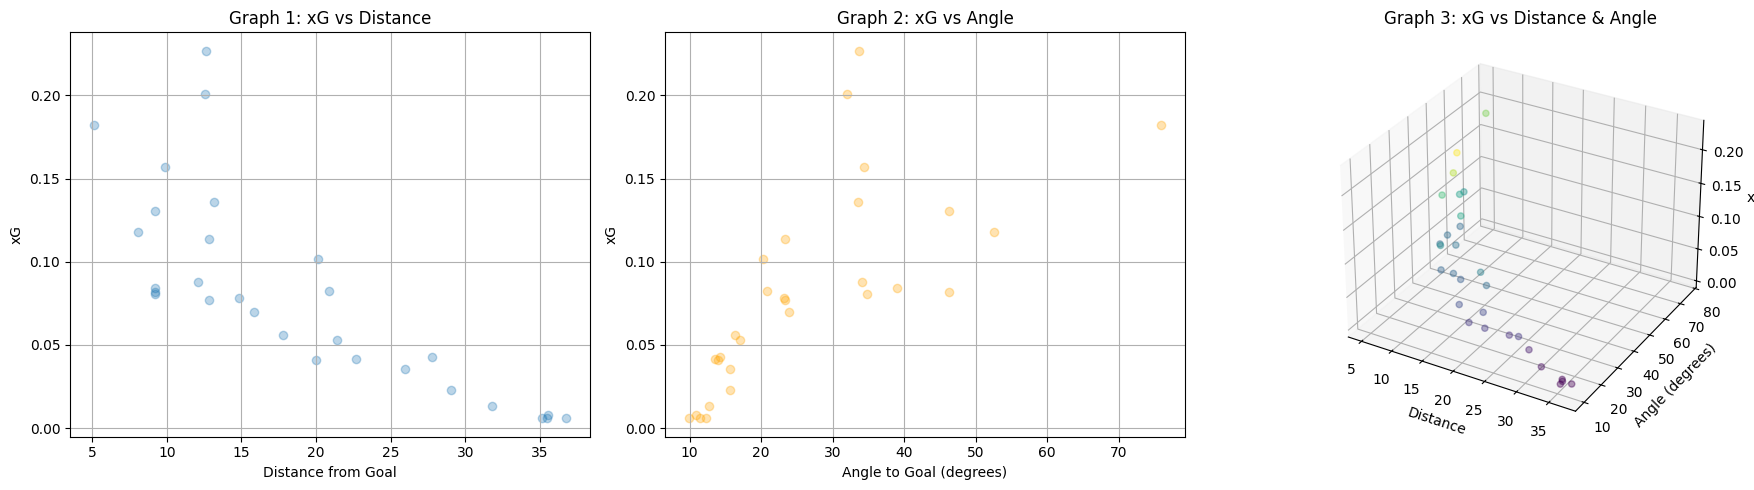

In [ ]:
# Visualizing the initial data
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(18, 5))

# Graph 1: xG vs Distance
ax1 = fig.add_subplot(1, 3, 1)
ax1.scatter(model_data['distance'], model_data['shot_statsbomb_xg'], alpha=0.3)
ax1.set_title("Graph 1: xG vs Distance")
ax1.set_xlabel("Distance from Goal")
ax1.set_ylabel("xG")
ax1.grid(True)

# Graph 2: xG vs Angle
ax2 = fig.add_subplot(1, 3, 2)
ax2.scatter(model_data['angle'] * (180 / np.pi), model_data['shot_statsbomb_xg'], alpha=0.3, color='orange')
ax2.set_title("Graph 2: xG vs Angle")
ax2.set_xlabel("Angle to Goal (degrees)")
ax2.set_ylabel("xG")
ax2.grid(True)

# Graph 3: 3D Plot — Distance, Angle, xG
ax3 = fig.add_subplot(1, 3, 3, projection='3d')
scatter = ax3.scatter(
    model_data['distance'],
    model_data['angle'] * (180 / np.pi),
    model_data['shot_statsbomb_xg'],
    c=model_data['shot_statsbomb_xg'],
    cmap='viridis',
    alpha=0.4
)
ax3.set_title("Graph 3: xG vs Distance & Angle")
ax3.set_xlabel("Distance")
ax3.set_ylabel("Angle (degrees)")
ax3.set_zlabel("xG")

plt.tight_layout()
plt.show()

Now we should do this for data from all of the games

In [ ]:
import warnings
warnings.filterwarnings("ignore")


In [ ]:
all_shots = []

for i, match_id in enumerate(matches['match_id'], start=1):
    match_row = matches[matches['match_id'] == match_id].iloc[0]
    home_team = match_row['home_team']
    away_team = match_row['away_team']
    stage = match_row['competition_stage']

    print(f"[{i}/{len(matches)}] Processing: {home_team} vs {away_team} ({stage}) — match_id: {match_id}")

    events = sb.events(match_id=match_id)
    shots = events[events['type'] == 'Shot'].copy()
    shots['distance'] = shots['location'].apply(get_distance)               # Save the distance of the shot from the goal line
    shots['angle'] = shots['location'].apply(get_angle)                     # Save the angle of the shot from the goal line
    shots['angle_degrees'] = shots['location'].apply(get_angle_degrees)     # this is again added for convenience and debugging, easier to read than radians

    shots['player'] = shots['player'].fillna('Unknown')
    shots['team'] = shots['team'].fillna('Unknown')
    shots['goal_label'] = shots['shot_outcome'].apply(lambda x: 'Goal' if isinstance(x, dict) and x.get('name') == 'Goal' else 'No Goal')

    all_shots.append(shots)

all_shots = pd.concat(all_shots, ignore_index=True) # Concatenate all the shots into a single DataFrame

[1/64] Processing: Colombia vs England (Round of 16) — match_id: 7585
[2/64] Processing: England vs Belgium (Group Stage) — match_id: 7570
[3/64] Processing: Sweden vs Switzerland (Round of 16) — match_id: 7586
[4/64] Processing: Iran vs Portugal (Group Stage) — match_id: 7557
[5/64] Processing: Portugal vs Morocco (Group Stage) — match_id: 7542
[6/64] Processing: Croatia vs England (Semi-finals) — match_id: 8656
[7/64] Processing: England vs Panama (Group Stage) — match_id: 7554
[8/64] Processing: Serbia vs Switzerland (Group Stage) — match_id: 7550
[9/64] Processing: Brazil vs Costa Rica (Group Stage) — match_id: 7548
[10/64] Processing: Egypt vs Uruguay (Group Stage) — match_id: 7578
[11/64] Processing: South Korea vs Mexico (Group Stage) — match_id: 7553
[12/64] Processing: Uruguay vs Saudi Arabia (Group Stage) — match_id: 7544
[13/64] Processing: Belgium vs Panama (Group Stage) — match_id: 7536
[14/64] Processing: Poland vs Colombia (Group Stage) — match_id: 7555
[15/64] Processin

In [ ]:
# Now we can train the model on all of the shot data
all_shots_df = pd.concat([all_shots], ignore_index=True) # Concatenate all the shots into a single DataFrame

# Do the same preprocessing as before
all_shots_df['distance'] = all_shots_df['location'].apply(get_distance)
all_shots_df['angle'] = all_shots_df['location'].apply(get_angle)
all_shots_df['angle_degrees'] = all_shots_df['angle'] * (180 / np.pi)

# Select the required columns for the model
required = ['player', 'team', 'distance', 'angle', 'angle_degrees',
            'shot_statsbomb_xg', 'shot_body_part', 'shot_technique',
            'shot_type', 'shot_outcome','goal_label']

model_data = all_shots_df[required].dropna().copy()


# Now we can train the model on all of the shot data
X = model_data[['distance', 'angle_degrees', 'shot_body_part', 'shot_technique', 'shot_type']]
y = model_data['shot_statsbomb_xg']

# Preprocessing the categorical features using OneHotEncoder
categorical_features = ['shot_body_part', 'shot_technique', 'shot_type']
numerical_features = ['distance', 'angle_degrees']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_features)
    ],
    remainder='passthrough'
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

print("MSE:", mean_squared_error(y_test, y_pred))
print("R²:", r2_score(y_test, y_pred))

MSE: 0.004459147811384246
R²: 0.8630706044730132


We have some decent results from this linear regression model so lets plot some results

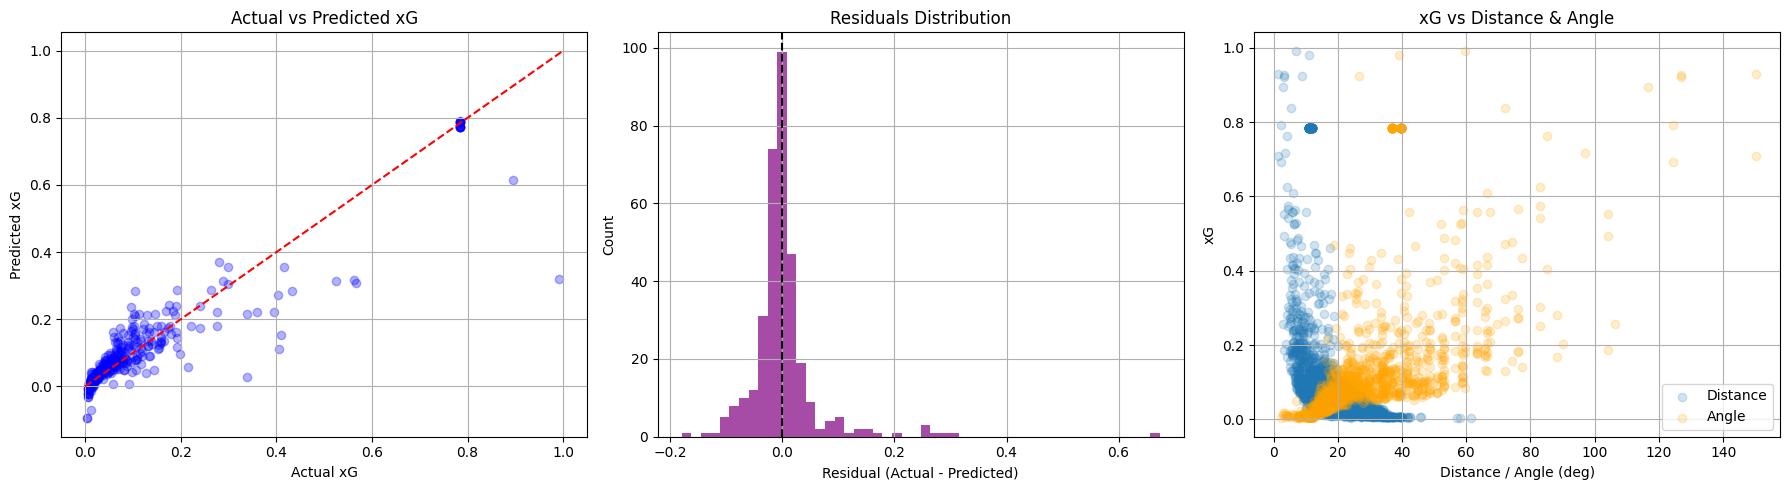

In [ ]:
residuals = y_test - y_pred  # Make sure these match in length

fig = plt.figure(figsize=(18, 5))

# Plot 1: Actual vs Predicted
ax1 = fig.add_subplot(1, 3, 1)
ax1.scatter(y_test, y_pred, alpha=0.3, color='blue')
ax1.plot([0, 1], [0, 1], 'r--')
ax1.set_xlabel("Actual xG")
ax1.set_ylabel("Predicted xG")
ax1.set_title("Actual vs Predicted xG")
ax1.grid(True)

# Plot 2: Residuals
ax2 = fig.add_subplot(1, 3, 2)
ax2.hist(residuals, bins=50, color='purple', alpha=0.7)
ax2.axvline(0, color='black', linestyle='--')
ax2.set_xlabel("Residual (Actual - Predicted)")
ax2.set_ylabel("Count")
ax2.set_title("Residuals Distribution")
ax2.grid(True)

# Plot 3: Distance & Angle vs xG
ax3 = fig.add_subplot(1, 3, 3)
ax3.scatter(model_data['distance'], model_data['shot_statsbomb_xg'], alpha=0.2, label='Distance')
ax3.scatter(model_data['angle_degrees'], model_data['shot_statsbomb_xg'], alpha=0.2, color='orange', label='Angle')
ax3.set_xlabel("Distance / Angle (deg)")
ax3.set_ylabel("xG")
ax3.set_title("xG vs Distance & Angle")
ax3.legend()
ax3.grid(True)

plt.tight_layout()
plt.show()

### LLM Integration

In [ ]:
# Now we can format the data for querying the model. This way we can use the LLM to query our model and ask questions about the data and expected results.
X_full = model_data[['distance', 'angle_degrees', 'shot_body_part', 'shot_technique', 'shot_type']] # Input Features

model_data['predicted_xg'] = pipeline.predict(X_full) # Add the predicted xG to the model data

Now lets make some functions so our LLM can interact with our model

In [ ]:
# Per Shot Questions
def get_highest_xg_shots(df, n=1): return df.sort_values('predicted_xg', ascending=False).head(n)

def get_lowest_xg_shots(df, n=1): return df.sort_values('predicted_xg').head(n)

def predict_xg(distance=12.0, angle_degrees=53.13, body_part='Right Foot', technique='Normal', shot_type='Open Play'):
    input_data = pd.DataFrame({
        'distance': [distance],
        'angle_degrees': [angle_degrees],
        'angle': [np.radians(angle_degrees)],
        'shot_body_part': [body_part],
        'shot_technique': [technique],
        'shot_type': [shot_type]
    })
    return pipeline.predict(input_data)[0]

# Per Player Questions (We filter out unknown players here)
def players_with_highest_avg_xg(df, n=1):
    return df.groupby('player')['predicted_xg'].mean().sort_values(ascending=False).head(n)

def players_with_lowest_avg_xg(df, n=1):
    return df.groupby('player')['predicted_xg'].mean().sort_values().head(n)

def players_with_highest_total_xg(df, n=1):
    return df.groupby('player')['predicted_xg'].sum().sort_values(ascending=False).head(n)

def players_with_lowest_total_xg(df, n=1):
    return df.groupby('player')['predicted_xg'].sum().sort_values().head(n)

def players_with_best_avg_xg_per_shot(df, n=1):
    avg = df.groupby('player')['predicted_xg'].mean().sort_values(ascending=False)
    return avg.head(n)

def players_with_worst_avg_xg_per_shot(df, n=1):
    avg = df.groupby('player')['predicted_xg'].mean().sort_values()
    return avg.head(n)

def players_with_highest_xg_per_goal(df, n=1):
    goals = df[df['goal_label'] == 'Goal']
    goal_counts = goals.groupby('player').size()
    xg_totals = df.groupby('player')['predicted_xg'].sum()
    xg_per_goal = (xg_totals / goal_counts).dropna().sort_values(ascending=False)
    return xg_per_goal.head(n)

def players_with_lowest_xg_per_goal(df, n=1):
    goals = df[df['goal_label'] == 'Goal']
    goal_counts = goals.groupby('player').size()
    xg_totals = df.groupby('player')['predicted_xg'].sum()
    xg_per_goal = (xg_totals / goal_counts).dropna().sort_values()
    return xg_per_goal.head(n)

# Per team questions
def teams_with_highest_total_xg(df, n=1):
    return df.groupby('team')['predicted_xg'].sum().sort_values(ascending=False).head(n)

def teams_with_lowest_total_xg(df, n=1):
    return df.groupby('team')['predicted_xg'].sum().sort_values().head(n)

def teams_with_highest_avg_xg(df, n=1):
    return df.groupby('team')['predicted_xg'].mean().sort_values(ascending=False).head(n)

def teams_with_lowest_avg_xg(df, n=1):
    return df.groupby('team')['predicted_xg'].mean().sort_values().head(n)

def teams_with_best_avg_xg_per_shot(df, n=1):
    avg = df.groupby('team')['predicted_xg'].mean().sort_values(ascending=False)
    return avg.head(n)

def teams_with_worst_avg_xg_per_shot(df, n=1):
    avg = df.groupby('team')['predicted_xg'].mean().sort_values()
    return avg.head(n)

def teams_with_highest_xg_per_goal(df, n=1):
    goals = df[df['goal_label'] == 'Goal']
    goal_counts = goals.groupby('team').size()
    xg_totals = df.groupby('team')['predicted_xg'].sum()
    xg_per_goal = (xg_totals / goal_counts).dropna().sort_values(ascending=False)
    return xg_per_goal.head(n)

def teams_with_lowest_xg_per_goal(df, n=1):
    goals = df[df['goal_label'] == 'Goal']
    goal_counts = goals.groupby('team').size()
    xg_totals = df.groupby('team')['predicted_xg'].sum()
    xg_per_goal = (xg_totals / goal_counts).dropna().sort_values()
    return xg_per_goal.head(n)


In [ ]:
# Find values allowed for parameters used in training the model:
print("Body Parts: ", all_shots_df['shot_body_part'].unique())
print("Shot Techniques: ", all_shots_df['shot_technique'].unique())
print("Shot Types: ", all_shots_df['shot_type'].unique())

Body Parts:  ['Right Foot' 'Head' 'Left Foot' 'Other']
Shot Techniques:  ['Normal' 'Volley' 'Diving Header' 'Half Volley' 'Lob' 'Overhead Kick'
 'Backheel']
Shot Types:  ['Free Kick' 'Open Play' 'Penalty']


In [ ]:
# Quick sanity checks (n=1 for speed)
print(get_highest_xg_shots(model_data, n=1))
print(get_lowest_xg_shots(model_data, n=1))

print(model_data.columns.tolist())

print(players_with_highest_total_xg(model_data, n=1))
print(players_with_lowest_total_xg(model_data, n=1))
print(players_with_best_avg_xg_per_shot(model_data, n=1))
print(players_with_worst_avg_xg_per_shot(model_data, n=1))
print(players_with_highest_xg_per_goal(model_data, n=1))
print(players_with_lowest_xg_per_goal(model_data, n=1))

print(teams_with_highest_total_xg(model_data, n=1))
print(teams_with_lowest_total_xg(model_data, n=1))
print(teams_with_highest_avg_xg(model_data, n=1))
print(teams_with_lowest_avg_xg(model_data, n=1))
print(teams_with_best_avg_xg_per_shot(model_data, n=1))
print(teams_with_worst_avg_xg_per_shot(model_data, n=1))
print(teams_with_highest_xg_per_goal(model_data, n=1))
print(teams_with_lowest_xg_per_goal(model_data, n=1))

print(predict_xg(distance=12.0, angle_degrees=53.13, body_part='Right Foot', technique='Normal', shot_type='Open Play'))
print(predict_xg(distance=11.0, angle_degrees=36.87, body_part='Left Foot', technique='Normal', shot_type='Penalty'))
print(predict_xg(distance=15.0, angle_degrees=35, body_part='Right Foot', technique='Volley', shot_type='Free Kick'))


                  player        team   distance    angle  angle_degrees  \
809  Bryan Ruiz González  Costa Rica  11.045361  0.69288      39.699073   

     shot_statsbomb_xg shot_body_part shot_technique shot_type shot_outcome  \
809             0.7835      Left Foot         Normal   Penalty         Post   

    goal_label  predicted_xg  
809    No Goal      0.790535  
                       player     team   distance     angle  angle_degrees  \
834  Diego Roberto Godín Leal  Uruguay  61.522354  0.128761        7.37746   

     shot_statsbomb_xg shot_body_part shot_technique  shot_type shot_outcome  \
834           0.002985     Right Foot         Volley  Open Play        Off T   

    goal_label  predicted_xg  
834    No Goal     -0.126159  
['player', 'team', 'distance', 'angle', 'angle_degrees', 'shot_statsbomb_xg', 'shot_body_part', 'shot_technique', 'shot_type', 'shot_outcome', 'goal_label', 'predicted_xg']
player
Harry Kane    4.466642
Name: predicted_xg, dtype: float64
player
Víc

Our Model outputs look good! Our LLM will now be able to answer specific xG related questions about the World Cup Data, and it can also use this data to predict xG given certain user scenarios!

We've built a schema of our functions in 'functions_schema.json'

In [ ]:
#!pip install openai
import openai
from openai import OpenAI
import json

In [ ]:
json_file = 'functions_schema.json'
functions = None
with open(json_file, 'r') as f:
    functions = json.load(f)

apikeyfolder = 'openaikey'
apikey = None
with open(apikeyfolder, 'r') as f:
   apikey = f.read().strip()

In [ ]:
client = OpenAI(api_key=apikey)

### Now we get to test our model <-> LLM Questions!

In [ ]:
# First we create a class for the Question -> Data Analysis -> Answer process
class XGAssistant:
    def __init__(self, model_data, functions, client):
        self.model_data = model_data
        self.functions = functions
        self.client = client

        self.function_map = {
            "predict_xg": lambda args: predict_xg(**args),
            "get_highest_xg_shots": lambda args: get_highest_xg_shots(model_data, **args),
            "get_lowest_xg_shots": lambda args: get_lowest_xg_shots(model_data, **args),
            "players_with_highest_total_xg": lambda args: players_with_highest_total_xg(model_data, **args),
            "players_with_lowest_total_xg": lambda args: players_with_lowest_total_xg(model_data, **args),
            "players_with_best_avg_xg_per_shot": lambda args: players_with_best_avg_xg_per_shot(model_data, **args),
            "players_with_worst_avg_xg_per_shot": lambda args: players_with_worst_avg_xg_per_shot(model_data, **args),
            "players_with_highest_xg_per_goal": lambda args: players_with_highest_xg_per_goal(model_data, **args),
            "players_with_lowest_xg_per_goal": lambda args: players_with_lowest_xg_per_goal(model_data, **args),
            "teams_with_highest_total_xg": lambda args: teams_with_highest_total_xg(model_data, **args),
            "teams_with_lowest_total_xg": lambda args: teams_with_lowest_total_xg(model_data, **args),
            "teams_with_highest_avg_xg": lambda args: teams_with_highest_avg_xg(model_data, **args),
            "teams_with_lowest_avg_xg": lambda args: teams_with_lowest_avg_xg(model_data, **args),
            "teams_with_best_avg_xg_per_shot": lambda args: teams_with_best_avg_xg_per_shot(model_data, **args),
            "teams_with_worst_avg_xg_per_shot": lambda args: teams_with_worst_avg_xg_per_shot(model_data, **args),
            "teams_with_highest_xg_per_goal": lambda args: teams_with_highest_xg_per_goal(model_data, **args),
            "teams_with_lowest_xg_per_goal": lambda args: teams_with_lowest_xg_per_goal(model_data, **args),
        }

    def ask(self, user_query):
        # First we need to get the function from the LLM based on the user query
        response = client.chat.completions.create(
            model="gpt-4-0613",
            messages=[
                {"role": "user", "content": user_query}
            ],
            functions=self.functions,
            function_call="auto"
        )

        call = response.choices[0].message.function_call
        func_name = call.name
        args = call.arguments

        result = self.function_map[func_name](json.loads(args))

        second_response = self.client.chat.completions.create(
            model="gpt-4-0613",
            messages=[
                {"role": "user", "content": user_query},
                {"role": "assistant", "function_call": call.model_dump()},
                {"role": "function", "name": func_name, "content": str(result)}
            ]
        )

        # print(result)

        return second_response.choices[0].message.content

In [ ]:
# Now we can create an instance of the XGAssistant class and ask it questions
assistant = XGAssistant(model_data, functions, client)

# Example questions to ask the assistant
print("Q: What is the xG of a shot from 12 yards out at a 30 degree angle using a volley?")
print("A:", assistant.ask("What is the xG of a shot from 12 yards out at a 30 degree angle using a volley?"))

print("Q: Which player has the highest total xG?")
print("A:", assistant.ask("Which player has the highest total xG?"))

print("Q: What team has the best average xG per shot?")
print("A:", assistant.ask("What team has the best average xG per shot?"))

Q: What is the xG of a shot from 12 yards out at a 30 degree angle using a volley?
A: The expected goals (xG) of a shot from 12 yards out at a 30 degree angle using a volley is approximately 0.144.
Q: Which player has the highest total xG?
A: The player with the highest total xG (expected goals) is Harry Kane with 4.47.
Q: What team has the best average xG per shot?
A: The team with the best average expected goals (xG) per shot is Russia.


In [ ]:
# Try it for yourself with a loop for user input!
user_input = ""
while user_input.lower() != "exit" or user_input.lower() != "q":
    user_input = input("Ask a question (or type 'exit' to quit): ")
    print("You:", user_input)
    if user_input.lower() != "exit" or user_input.lower() != "q":
        print("Assistant:", assistant.ask(user_input))

You: What is the xG of a shot from a distance of 16m and angle of 55 degrees?
Assistant: The xG of a shot from a distance of 16m and angle of 55 degrees is approximately 0.268.
You: Which player had the lowest xG per goal
Assistant: I am sorry but I couldn't find information about any player who holds the record for the lowest xG per goal.
You: Which team had the highest average xG
Assistant: The team with the highest average xG was Russia.
You: What is the xG of a penalty which is at 11 meters out at about an angle of 36 degrees
Assistant: The Expected Goals (xG) value of a penalty taken from 11 meters out at an angle of about 36 degrees is approximately 0.771. This means there is about a 77.1% chance of scoring from this shot.
You: exit


AttributeError: 'NoneType' object has no attribute 'name'

**Summary:**  
I successfully built a multimodal project from scratch using free, open-source data from StatsBomb. I trained a simple linear regression model to predict expected goals (xG) based on shot data from the 2018 World Cup. On top of that, I created a set of functions that allowed an LLM to interact with both the dataset and my model's generating predictions in response to natural language questions. I then used the same LLM to format and present those results in a user friendly way.

For future improvements, I would likely refine the LLM function interface for better flexibility and expand the model itself. A more advanced xG model using a richer dataset would capture more relevant and accurate predictions, since linear regression is quite limited in what it can represent. I would also like to include a larger set of functions to ask questions regarding data and include more fields for querying xG (e.g. "How much would the xG be if Cristiano Ronaldo took a penalty versus Romelu Lukaku?")
